## Dataset Description 

https://github.com/walkerkq/musiclyrics

Billboard has published a Year-End Hot 100 every December since 1958. The chart measures the performance of singles in the U.S. throughout the year. Using R, I’ve combined the lyrics from 50 years of Billboard Year-End Hot 100 (1965-2015) into one dataset for analysis. You can download that dataset here.

The songs used for analysis were scraped from Wikipedia’s entry for each Billboard Year-End Hot 100 Songs (e.g., 2014). This is the year-end chart, not weekly rankings. Many artists have made the weekly chart but not the final year end chart. The final chart is calculated using an inverse point system based on the weekly Billboard charts (100 points for a week at number one, 1 point for a week at number 100, etc).

I used the xml and RCurl packages to scrape song and artist names from each Wikipedia entry. I then used that list to scrape lyrics from sites that had predictable URL strings (for example, metrolyrics.com uses metrolyrics.com/SONG-NAME-lyrics-ARTIST-NAME.html). If the first site scrape failed, I moved onto the second, and so on. About 78.9% of the lyrics were scraped from metrolyics.com, 15.7% from songlyrics.com, 1.8% from lyricsmode.com. About 3.6% (187/5100) were unavailable.

The dataset features 5100 observations with the features rank (1-100), song, artist, year, lyrics, and source. The artist feature is fairly standardized thanks to Wikipedia, but there is still quite a bit of noise when it comes to artist collaborations (Justin Timberlake featuring Timbaland, for example). If there were any errors in the lyrics that were scraped, such as spelling errors or derivatives like "nite" instead of "night," they haven't been corrected.

Full analysis can be found here.

# Imports and Data Loading

In [11]:
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

from Levenshtein import distance as levenshtein_distance

import matplotlib.pyplot as plt

### Chords Dataset

In [12]:
def songname(url):
    return url.split("/")[-1].replace(".htm", "").replace("_", " ").replace("crd", "").replace("ukulele", "")

In [13]:
def artistname(url):
    return url.split("/")[-2].replace("_", " ")

In [14]:
chords_file = "song_chords.txt"

df_chords = pd.read_csv(chords_file, sep="\t", header=0, names=["url", "chords"])
df_chords["url"] = df_chords["url"].apply(lambda s : s.strip())
df_chords["Song"] = df_chords["url"].apply(songname)
df_chords["Artist"] = df_chords["url"].apply(artistname)

df_chords.head()

,url,chords,Song,Artist
0,https://tabs.ultimate-guitar.com/a/a/a_ver2_cr...,"['F', 'D#', 'F', 'D#', 'F', 'D#', 'F', 'D#', '...",a ver2,a
1,https://tabs.ultimate-guitar.com/a/a/a_ukulele...,[],a,a
2,https://tabs.ultimate-guitar.com/a/a/hopper_jo...,"['A', 'D', 'A', 'D', 'A', 'D', 'A', 'D', 'A', ...",hopper jonnus fang,a
3,https://tabs.ultimate-guitar.com/a/a/hopper_jo...,"['A', 'D', 'A', 'D', 'A', 'D', 'A', 'D', 'A', ...",hopper jonnus fang,a
4,https://tabs.ultimate-guitar.com/a/a/inikah_ci...,"['A', 'C#m', 'Bm', 'E', 'A', 'Bm', 'E', 'A', '...",inikah cinta,a


In [15]:
df_chords[df_chords.Artist.str.contains("ma")]

,url,chords,Song,Artist
25,https://tabs.ultimate-guitar.com/a/a_banda_mai...,"['D', 'G', 'D', 'G', 'D', 'G', 'D', 'D', 'G', ...",potinhos,a banda mais bonita da cidade
26,https://tabs.ultimate-guitar.com/a/a_banda_mai...,"['G', 'Em7', 'G', 'D', 'A', 'F#', 'Bm', 'Bm7',...",terminei indo,a banda mais bonita da cidade
390,https://tabs.ultimate-guitar.com/a/a_r_rahman_...,"['C', 'Am', 'F', 'Em', 'Am', 'F', 'E', 'Am', '...",tu koi aur hai,a r rahman alma ferovic arjun chandy
668,https://tabs.ultimate-guitar.com/a/a_r_rahman/...,"['C', 'G', 'D', 'C', 'G', 'D', 'C', 'G', 'D', ...",call me dil,a r rahman
669,https://tabs.ultimate-guitar.com/a/a_r_rahman/...,"['F', 'C', 'G', 'F', 'C', 'G', 'F', 'C', 'G', ...",call me dil,a r rahman
...,...,...,...,...
41651,https://tabs.ultimate-guitar.com/c/chris_norma...,"['C', 'F', 'F', 'G', 'G', 'C', 'C', 'F', 'F', ...",wish you well,chris norman
42018,https://tabs.ultimate-guitar.com/c/chris_thoma...,"['A', 'D', 'E', 'A', 'D', 'A', 'D', 'A', 'E', ...",superstitious blues,chris thomas king
42233,https://tabs.ultimate-guitar.com/c/chrisma_abi...,"['A', 'F#m', 'Bm', 'E', 'A', 'F#m', 'Bm', 'E',...",meri aama,chrisma abigail
42239,https://tabs.ultimate-guitar.com/c/christ_chur...,"['C#', 'G#', 'D#', 'G#/C', 'C#', 'D#', 'C#', '...",where o grave,christ church mayfair


### Lyrics Top-100 dataset

In [43]:
data_file_incomplete = "datasets/billboard_lyrics_1964-2015.csv"
data_file = "datasets/billboard_full.csv"

df_incomplete = pd.read_csv(data_file_incomplete, encoding = "ANSI") # utf-8 encoding doesn't work somehow :(
df = pd.read_csv(data_file, index_col=0, header=0) 

df.head()

,Rank,Song,Artist,Year,Lyrics,Genre,Album
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,rock,wooly bully
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love you...,r&b soul,greatest hits in concert
2,3,i cant get no satisfaction,the rolling stones,1965,i cant get no satisfaction i cant get no satis...,rock,out of our heads
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,folk,love me not tomorrow
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,r&b soul,top gun


In [66]:
len(df.Artist.unique())

2471

### Joining datasets

In [53]:
df_chords.xs(10000).url

'https://tabs.ultimate-guitar.com/a/aly_aj/in_a_second_ukulele_crd.htm'

In [43]:
def findchords(song):
    distances = df_chords["Song"].apply(lambda s : levenshtein_distance(s, song))
    return df_chords[["Song", "url", "chords"]].xs(distances.idxmin())

In [44]:
df["chords"] = df.Song.apply(findchords)

In [47]:
df.tail(20)

,Rank,Song,Artist,Year,Lyrics,Source,chords
5080,81,lay me down,sam smith,2015,yes i do i believe that one day i will be whe...,1.0,lay me down crd
5081,82,tuesday,ilovemakonnen featuring drake,2015,hook x4 club goin up on a tuesday got your gir...,3.0,tuesday crd
5082,83,hit the quan,ilovememphis,2015,yo yo aye im finna aye im finnaim finna show ...,1.0,hit it crd
5083,84,downtown,macklemore and ryan lewis featuring eric nally...,2015,i went to the moped store said fuck it salesm...,1.0,downtown crd
5084,85,house party,sam hunt,2015,youre on the couch blowing up my phone you do...,1.0,house crd
5085,86,ayo,chris brown and tyga,2015,i need you i need you i need you i need you i...,1.0,a crd
5086,87,kick the dust up,luke bryan,2015,all week long its a farmin town theyre makin ...,1.0,in the dust crd
5087,88,blessings,big sean featuring drake,2015,look i feel blessed way up i feel blessed way...,1.0,guessing crd
5088,89,budapest,george ezra,2015,my house in budapest my hidden treasure chest...,1.0,luha crd
5089,90,chandelier,sia,2015,party girls dont get hurt cant feel anything ...,1.0,changes crd


## Number of years in Top 100 per Song

In [46]:
df_count = df.groupby(["Artist", "Song"]).Year.agg(list).to_frame()
df_count["Count"] = df_count.Year.apply(len)
df_count = df_count.sort_values("Count", ascending = False)
df_count.head()

,,Year,Count
Artist,Song,,
psy,gangnam style,"[2012, 2013]",2
chingy featuring ludacris and snoop dogg,holidae in,"[2003, 2004]",2
snap,rhythm is a dancer,"[1992, 1993]",2
the band perry,if i die young,"[2010, 2011]",2
katy perry,hot n cold,"[2008, 2009]",2


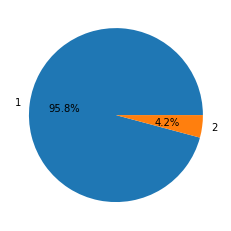

In [47]:
plt.pie(df_count["Count"].value_counts(), labels = [1, 2], autopct='%1.1f%%')
plt.show()

## Number of songs in top 100 per artist (if a song is twice, is counted twice)

In [15]:
df.Artist.value_counts().describe()

count    2473.000000
mean        2.062273
std         2.475152
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        35.000000
Name: Artist, dtype: float64

In [16]:
df_songCounts = df.groupby("Artist").Song.count()
df_rndArtist = df_songCounts.to_frame().reset_index().groupby("Song").agg(list)
df_rndArtist["Artist"] = df_rndArtist["Artist"].apply(lambda a : np.random.choice(a, 1)[0])

df_labels = pd.DataFrame(range(1, df_songCounts.max() + 1), columns = ["Song"])
df_labels["Artist"] = ""
df_labels = df_labels.set_index("Song")
df_labels.update(df_rndArtist)

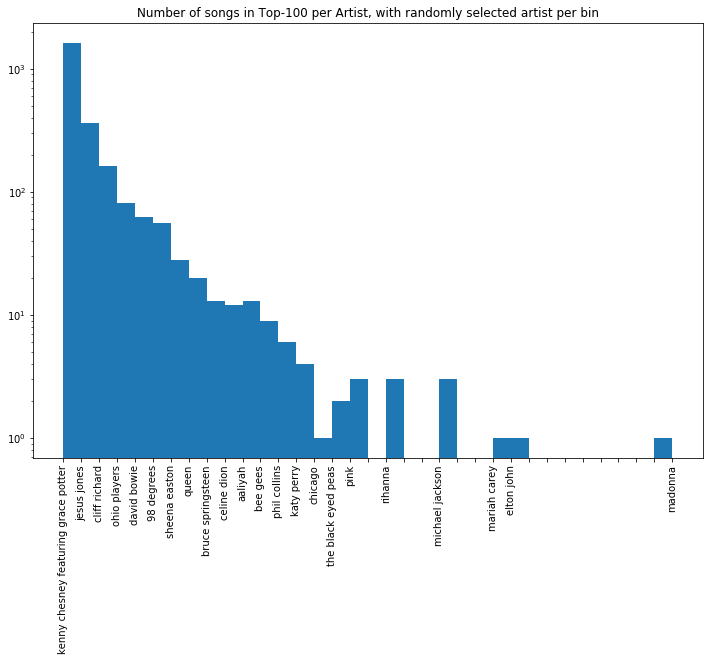

In [17]:
bins = range(1, df_songCounts.max() + 1)
plt.figure(figsize=(12,8))
plt.hist(df_songCounts, bins = bins)
plt.xticks(bins, df_labels["Artist"], rotation='vertical')
plt.yscale("log")
plt.title("Number of times appearing in Top-100 per Artist, with randomly selected artist per bin")
plt.show()

### Clusterisation of texts

In [25]:
from nltk import pos_tag, sent_tokenize, wordpunct_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 

def lemmatize(token, pos_tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(pos_tag[0], wn.NOUN)
    return lemmatizer.lemmatize(token, tag)

def preprocess_lyrics(lyrics):
    tagged_tokens = pos_tag(wordpunct_tokenize(lyrics))
    preprocessed = [lemmatize(token, tag) for (token, tag) in tagged_tokens if not token in stop_words]
    return " ".join(preprocessed)

In [26]:
preprocessed_lyrics = df.Lyrics.fillna("").apply(preprocess_lyrics)

In [27]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english', preprocessor = None)
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(preprocessed_lyrics)

In [38]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 2
number_words = 4
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
la na say come

Topic #1:
love im know dont


In [39]:
vectors_10 = lda.transform(count_data)

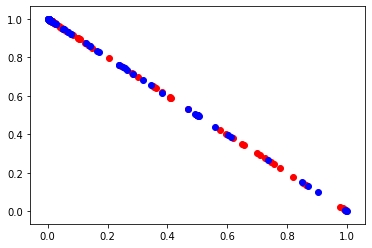

In [40]:
plt.scatter(vectors_10[:100, 0], vectors_10[:100, 1], color = "red")
plt.scatter(vectors_10[5000:, 0], vectors_10[5000:, 1], color = "blue")

plt.show()

In [30]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(2)
vectors_2 = svd.fit_transform(vectors_10)

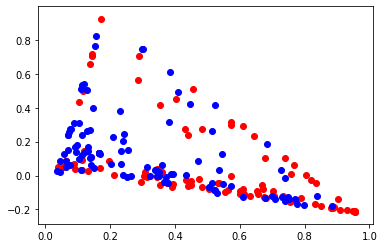

In [37]:
plt.scatter(vectors_2[:100, 0], vectors_2[:100, 1], color = "red")
plt.scatter(vectors_2[5000:, 0], vectors_2[5000:, 1], color = "blue")

plt.show()

## Using Doc2Vec

In [41]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc.split(" "), [i]) for i, doc in enumerate(df.Lyrics.fillna(""))]
model = Doc2Vec(documents, vector_size=300, window=4, min_count=1, workers=4, epochs = 10, dbow_words = 1)

In [42]:
sentence = "I cant get no satisfaction"
vector = model.infer_vector(sentence.split(" "))
documents[model.docvecs.most_similar([vector])[1][0]]

TaggedDocument(words=['', '', ''], tags=[2219])

In [96]:
6
54documents[4480]

TaggedDocument(words=' you know i like my chicken fried cold beer on a friday night a pair of jeans that fit just right and the radio upwell i was raised up beneath the shade of a georgia pine and thats home you know with sweet tea pecan pie and homemade wine where the peaches grow and my house its not much to talk about but its filled with love thats grown in southern ground and a little bit of chicken friedcold beer on a friday night a pair of jeans that fit just right and the radio up well ive seen the sunrise see the love in my womans eyes feel the touch of a precious child and know a mothers loveand its funny how its the little things in life that mean the most not where you live what you drive or the price tag on your clothes theres no dollar sign on a piece of mind this ive come to know so if you agree have a drink with me raise your glasses for a toast to a little bit of chicken friedcold beer on a friday night a pair of jeans that fit just right and the radio up well ive seen 

In [55]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(2)
vectors_2 = svd.fit_transform(model.docvecs.vectors_docs)

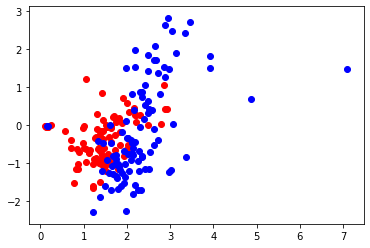

In [56]:
plt.scatter(vectors_2[:100, 0], vectors_2[:100, 1], color = "red")
plt.scatter(vectors_2[5000:, 0], vectors_2[5000:, 1], color = "blue")

plt.show()

## TODO : explore with same vocabulary basis per decade